In [2]:
%matplotlib inline
import pandas as pd
import dateutil.parser
from collections import defaultdict
import matplotlib.pyplot as plt
from cabin_sizes import get_cabin_sizes
from datetime import timedelta
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [3]:
!ls data

downsampled  koiedata.csv


## Read and process the data

Download link for data: https://s3.eu-central-1.amazonaws.com/koiene-data/koiedata.csv

In [4]:
df = pd.read_csv("data/koiedata.csv", encoding="utf-8")
df.head(5)

,koiename,n_mem,n_non_mem,date
0,Agdenes,2,0,1999-10-08
1,Agdenes,5,2,1999-10-09
2,Agdenes,6,1,1999-10-15
3,Agdenes,6,1,1999-10-16
4,Agdenes,5,5,1999-10-22


Create categorical column, and parse dates to date object. Duplicate date into columns for differenct components and extract values.

## Data Transformation

In [5]:
df.head(2)

,koiename,n_mem,n_non_mem,date
0,Agdenes,2,0,1999-10-08
1,Agdenes,5,2,1999-10-09


We don't care if the beds were for members or non-members. Create date objects, and use these as index for the data frame.

In [6]:
df["koiename"] = pd.Categorical(df.koiename)
df["date"] = pd.to_datetime(df["date"])
df.index = pd.DatetimeIndex(df.date)
df["reserved"] = df["n_mem"] + df["n_non_mem"]
df = df.drop(["n_mem", "n_non_mem", "date"], axis=1)
df.head(2)

,koiename,reserved
date,,
1999-10-08,Agdenes,2
1999-10-09,Agdenes,7


To transform the problem to a classification problem we transform the number of reserved beds to three categories: `EMPTY`, `PARTIAL`, and `FULL`.

In [7]:
def get_class(row):
    lim = get_cabin_sizes()[row["koiename"]]
    if row["reserved"] >= lim:
        return "FULL"
    elif row["reserved"] == 0:
        return "EMPTY"
    return "PARTIAL"

df["class"] = df.apply(get_class, axis=1)
df = df.drop("reserved", axis=1)

In [8]:
df.head(5)

,koiename,class
date,,
1999-10-08,Agdenes,PARTIAL
1999-10-09,Agdenes,PARTIAL
1999-10-15,Agdenes,PARTIAL
1999-10-16,Agdenes,PARTIAL
1999-10-22,Agdenes,FULL


### Creating data frames for each cabin

The data has missing data for some dates, and different cabins were part of the network at different times. Therefore we create seperate data frames for each cabin and infer missing values (if there are any) for each of them.

In [9]:
def create_cabin_frame(original, cabin):
    cdf = original.loc[original["koiename"] == cabin]
    min_date = cdf.index.min()
    max_date = cdf.index.max()
    idx = pd.date_range(min_date, max_date)
    cdf = cdf.reindex(idx)
    cdf["koiename"].fillna(cabin, inplace=True)
    cdf["class"].fillna("EMPTY", inplace=True)
    return cdf


In [10]:
extdf = pd.DataFrame()

for cabin_name in get_cabin_sizes().keys():
    extdf = extdf.append(create_cabin_frame(df, cabin_name))

df = extdf

### Class Distribution (extended data frame)

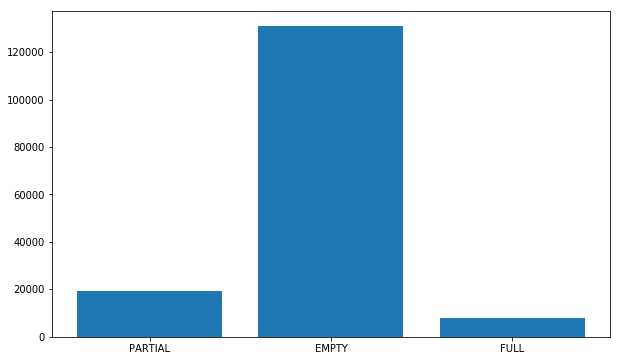

In [11]:
per_class = defaultdict(int)
for _, row in extdf.iterrows():
    per_class[row["class"]] += 1
plt.figure(figsize=(10,6))
plt.bar(per_class.keys(), per_class.values());

As we can see, `EMPTY` is by far the most common class for cabins. This is as expected, but we need to take this into consideration when training our models.

### Feature Transformation
Add year, month, week, and day of week as features.

In [12]:
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.strftime('%U')
df["day_of_week"] = df.index.weekday
df.head(2)

,koiename,class,year,month,week,day_of_week
1999-10-08,Agdenes,PARTIAL,1999,10,40,4
1999-10-09,Agdenes,PARTIAL,1999,10,40,5


Sinus and cosinus encode cyclical values.

In [13]:
df["week"] = df.week.astype(int)
df["sin_month"] = np.sin((df.month-1)*(2.*np.pi/12))
df["cos_month"] = np.cos((df.month-1)*(2.*np.pi/12))
df["sin_week"] = np.sin((df.week-1)*(2.*np.pi/52))
df["cos_week"] = np.cos((df.week-1)*(2.*np.pi/52))
df["sin_day_of_week"] = np.sin((df.day_of_week-1)*(2.*np.pi/7))
df["cos_day_of_week"] = np.cos((df.day_of_week-1)*(2.*np.pi/7))
df = df.drop(["month", "week", "day_of_week"], axis=1)

In [14]:
df.head(2)

,koiename,class,year,sin_month,cos_month,sin_week,cos_week,sin_day_of_week,cos_day_of_week
1999-10-08,Agdenes,PARTIAL,1999,-1.0,-1.836970e-16,-1.0,-1.836970e-16,0.433884,-0.900969
1999-10-09,Agdenes,PARTIAL,1999,-1.0,-1.836970e-16,-1.0,-1.836970e-16,-0.433884,-0.900969


Normalize the year.

In [15]:
mean = df["year"].mean()
std = df["year"].std()
print("Year mean:", mean)
print("Year std:", std)
df["year"] = (df["year"]-mean)/std

Year mean: 2008.7080231020807
Year std: 5.490381676700227


In [16]:
df.head(2)

,koiename,class,year,sin_month,cos_month,sin_week,cos_week,sin_day_of_week,cos_day_of_week
1999-10-08,Agdenes,PARTIAL,-1.768187,-1.0,-1.836970e-16,-1.0,-1.836970e-16,0.433884,-0.900969
1999-10-09,Agdenes,PARTIAL,-1.768187,-1.0,-1.836970e-16,-1.0,-1.836970e-16,-0.433884,-0.900969


In [17]:
df = pd.concat([df, pd.get_dummies(df.koiename)], axis=1)
df = df.drop("koiename", axis=1)

In [18]:
df.head(2)

,class,year,sin_month,cos_month,sin_week,cos_week,sin_day_of_week,cos_day_of_week,Agdenes,Brygga,...,Rindalsløa,Selbukåten,Sonvasskoia,Stabburet,Stakkslettsbua,Stallen,Taagaabu,Telin,Vekvessætra,Øvensenget
1999-10-08,PARTIAL,-1.768187,-1.0,-1.836970e-16,-1.0,-1.836970e-16,0.433884,-0.900969,1,0,...,0,0,0,0,0,0,0,0,0,0
1999-10-09,PARTIAL,-1.768187,-1.0,-1.836970e-16,-1.0,-1.836970e-16,-0.433884,-0.900969,1,0,...,0,0,0,0,0,0,0,0,0,0


### Data partitioning

In [19]:
df["class"].value_counts()

EMPTY      130960
PARTIAL     19111
FULL         8010
Name: class, dtype: int64

In [27]:
class_to_num = {"EMPTY": 0, "PARTIAL": 1, "FULL": 2}

#### Downsampling of majority classes

In [28]:
n = df["class"].value_counts()["FULL"]
df_empty = df.loc[df["class"] == "EMPTY"]
df_partial = df.loc[df["class"] == "PARTIAL"]
df_full = df.loc[df["class"] == "FULL"]
df_empty_down = resample(df_empty, replace=False, n_samples=n)
df_partial_down = resample(df_partial, replace=False, n_samples=n)

df_downsampled = pd.concat([df_empty_down, df_partial_down, df_full])
df_downsampled["target"] = df_downsampled["class"]
df_downsampled = df_downsampled.drop("class", axis=1)
df_downsampled["target"] = df_downsampled["target"].replace(class_to_num)

In [32]:
df_downsampled

,year,sin_month,cos_month,sin_week,cos_week,sin_day_of_week,cos_day_of_week,Agdenes,Brygga,Flåkoia,...,Selbukåten,Sonvasskoia,Stabburet,Stakkslettsbua,Stallen,Taagaabu,Telin,Vekvessætra,Øvensenget,target
2012-05-14,0.599590,8.660254e-01,-5.000000e-01,0.748511,-6.631227e-01,-0.781831,0.623490,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-08-27,-0.857504,-5.000000e-01,-8.660254e-01,-0.748511,-6.631227e-01,0.433884,-0.900969,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-07-28,0.235316,1.224647e-16,-1.000000e+00,-0.354605,-9.350162e-01,0.781831,0.623490,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-11-20,0.781727,-8.660254e-01,5.000000e-01,-0.748511,6.631227e-01,0.781831,0.623490,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-04-29,0.053180,1.000000e+00,6.123234e-17,0.935016,-3.546049e-01,0.781831,0.623490,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-09-26,1.328137,-8.660254e-01,-5.000000e-01,-0.992709,-1.205367e-01,-0.781831,0.623490,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2004-12-14,-0.857504,-5.000000e-01,8.660254e-01,-0.354605,9.350162e-01,0.000000,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-03-07,-0.857504,8.660254e-01,5.000000e-01,0.885456,4.647232e-01,-0.974928,-0.222521,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2012-01-30,0.599590,0.000000e+00,1.000000e+00,0.464723,8.854560e-01,-0.781831,0.623490,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2010-03-24,0.235316,8.660254e-01,5.000000e-01,0.970942,2.393157e-01,0.781831,0.623490,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Split into test and train set. Save the resulting data.

In [33]:
train, test = train_test_split(df_downsampled, test_size=0.3)
train.to_csv("data/downsampled/train.csv", index=False)
test.to_csv("data/downsampled/test.csv", index=False)